# 积分图快速边缘保留滤波算法

## 一：基本原理

传统的图像边缘保留滤波算法-如高斯双边模糊、Mean-Shift模糊等计算复杂、效率比较低，虽然有各种手段优化或者快速计算方法，当时算法相对一般码农来说理解起来比较费劲，不是一个的选择，而通过积分图像实现局部均方差的边缘保留模糊算法，计算简单而且可以做到计算量跟半径无关、跟上面提到两种边缘保留滤波(EPF)算法效率高很多。首先局部均方差滤波中计算局部均值的公式如下：

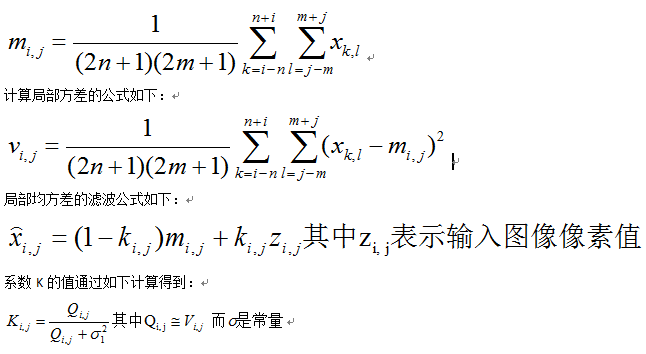

当边缘很弱的时候系数K趋近于0、该点的矫正之后的像素值就接近平均值。而当边缘很强的时候系数K趋近于1、该点的模糊之后的像素值就接近等于输入像素值。上述计算中最中意的是窗口内像素的均值与方差，计算均值可以根据积分图像很容易得到，而计算方差根据一系列的数学推导可以得到如下：

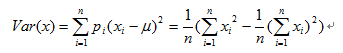

就是说可以根据积分图像通过常量次数的计算得到局部的均值与方差，让这种情况下的滤波变成一个常量时间完成的操作与窗口半径大小无关。

## 二：算法流程

1. 根据输入的图像计算得到积分图像

2. 根据输入的半径大小计算窗口内像素均值与方差、计算得到每个像素新的像素值

3. 循环每个个像素，重复第2步计算，得到最终的局部均方差滤波图像

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage
import skimage.io
import imageio

In [3]:
src = imageio.imread('../datas/face4.jpg')
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)

In [102]:
def sum_region(top_left, bottom_right, integral_image):
    #Getting co-ordinates
    tlx, tly = top_left[0], top_left[1]
    brx, bry = bottom_right[0], bottom_right[1]
    #Getting values of the edge points
    A = integral_image[tlx][tly]
    B = integral_image[tlx][bry]
    C = integral_image[brx][tly]
    D = integral_image[brx][bry]
    #Calculating sum
    S = D - B - C + A
    return S

In [103]:
def intergal_mean_shift(src,sigma=2.5,radius=5):
# 1.计算积分图你
    srcf = np.float32(src)
    intergal_img = cv2.integral(srcf,cv2.CV_32FC3)
    # radius = 5
    size = (radius * 2 + 1) ** 2
    # sigma = 2.0
    sigma2 = sigma ** 2
    rows,cols = src.shape[0],src.shape[1]
    dst = np.zeros_like(srcf)
    # 保边滤波
    for i in range(radius * 2 + 1,rows - radius * 2 - 1):
        for j in range(radius* 2 + 1,cols - radius* 2 - 1):
            sum_blocks = sum_region((i,j),(i+radius * 2 + 1,j+radius*2+1),intergal_img)

            mean_val = sum_blocks / size
            std_val = (mean_val - sum_blocks ** 2) / size / size
            k = std_val / (std_val + sigma2)
            pixel = srcf[i,j]
            new_pixel = (1.0 - k) * mean_val + k * pixel
            dst[i,j] = new_pixel

    dst = np.clip(dst,0,255)
    dst = np.uint8(dst)
    return dst

In [104]:
dst = intergal_mean_shift(src,sigma=2.5,radius=5)

Text(0.5,1,'DST')

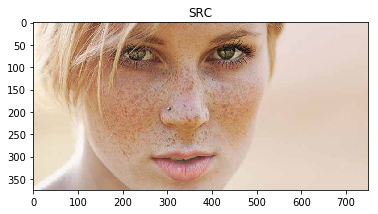

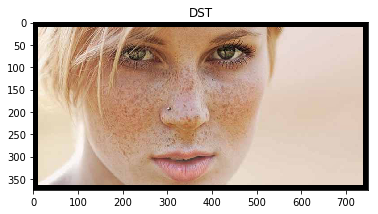

In [105]:
plt.figure()
plt.imshow(src)
plt.title('SRC')
plt.figure()
plt.imshow(dst)
plt.title('DST')

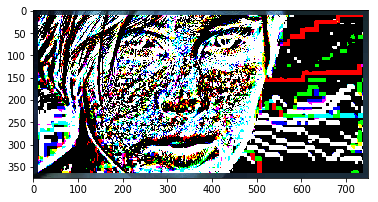

In [106]:
diff = dst - src
diff[diff < 0] = 0
plt.imshow(diff)

In [4]:
# No adaptative lapacian
def no_adaptive_usm(img,lambda_val,kernel_size,kernel_sigma):
    src = np.float32(img)
    rows,cols,=src.shape[0],src.shape[1]
    kernel = np.zeros((kernel_size,kernel_size),dtype=np.float32)
    for i in range(kernel_size):
        for j in range(kernel_size):
            if i == 8 and j == 8:
                kernel[i,j] = 79723.18339100346
            else:
                kernel[i,j] = -276.8166089965398

    z = np.zeros((rows,cols),dtype=src.dtype)
    z = cv2.filter2D(src,-1,kernel)
    
    max_z,max_src = 0,0
    max_z = np.max(np.abs(z))
    max_src = np.max(np.abs(src))
        
    z = z * (lambda_val * max_src / max_z)
    u = np.zeros_like(z)
    u = src + z
    u = np.clip(u,0,255)
    u = np.uint8(u)
    
    return u

# LoG
def fspecial_log(src,kernel_size=3,kernel_sigmal=1.0):
    gaussian_kernel = cv2.getGaussianKernel(kernel_size,kernel_sigmal,cv2.CV_64F)
    dst_kernel = cv2.mulTransposed(gaussian_kernel,gaussian_kernel,False)
    return dst_kernel

In [45]:
# img Input Image
#  w = Search window anchor size
#  w_n = Neighborhood anchor size
#  sigma_r = gaussian strength
def fast_NLM_filter(im,w,w_n,sigma_r):
    G = im.copy().astype(np.float32) / 255.0
    if len(im.shape) > 2:
        G = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY).astype(np.float32)
    size_y,size_x = G.shape
    R = np.zeros_like(G)
    II2 = cv2.integral(G ** 2)
    
    # Computing Gaussian domain weigths
    sigma_s = w // 1.5
    X,Y = np.meshgrid(np.arange(-w,w+1),np.arange(-w,w+1))
    S = X + Y
#     print('S:',S.shape)
    S = S / (-2 * (sigma_r ** 2))
    GaussW = np.exp(S)
#     print('GassuW:',GaussW.shape)
    U = no_adaptive_usm(G,3,17,0.005)
    
    for i in range(size_y):
        for j in range(size_x):
            if (i > w + w_n) and (j > w + w_n) and (i < size_y - w - w_n) and (j < size_x - w - w_n):
                # Extract local 
                iMin = max(i - w - w_n,0)
                iMax = min(i + w + w_n,size_y)
                jMin = max(j- w - w_n,0)
                jMax = max(j + w + w_n,size_x)
                
                # Get current window
                I = G[iMin:iMax,jMin:jMax]
#                 print('I.shape:',I.shape)
                sizeW_y,sizeW_x = I.shape
                O = np.zeros((sizeW_y - 2 * w_n+1,sizeW_x - 2 * w_n+1))
#                 print('O:',O.shape)
                # Extract pixel neighborhood P local region.
                mMin_p = i - w_n
                mMax_p = i + w_n
                nMin_p = j - w_n
                nMax_p = j + w_n
                
                # Get sum of squad neighborhood P
                sum_p = II2[mMin_p, nMin_p] + II2[mMax_p+1,nMax_p+1] - II2[mMin_p,nMax_p+1] - II2[mMax_p+1,nMin_p]
                
                # Get current neighborhood P
                neighbor_p = G[mMin_p:mMax_p, nMin_p:nMax_p]
#                 print('meighbor_p:',neighbor_p.shape)
                sizeP_y,sizeP_x = neighbor_p.shape
                
                # Perform correlation
                # output size
                mm = sizeW_y + sizeP_y - 1
                nn = sizeW_x + sizeP_x - 1
#                 print(mm,nn)
                # pad, multiply and transform back
                C = np.real(np.fft.ifft2(np.fft.fft2(I,[mm,nn]) * np.fft.fft2(np.rot90(neighbor_p),[mm,nn])))
                
                # padding constants (for output of size == size(A))
                padC_m = int(np.ceil((sizeP_y-1) /2))
                padC_n = int(np.ceil((sizeP_x-1) /2))
                # convolution result
                correlation = C[padC_m+1:sizeW_y+padC_m, padC_n+1:sizeW_x+padC_n]
                
#                 print(O.shape)
#                 print('sizeW_y - w_n:,sizeW_x - w_n:',sizeW_y - w_n,sizeW_x-w_n)
#                 print('correlation:',correlation.shape)
                for m in range(1+w_n,sizeW_y-w_n):
                    mMin_w = iMin + m-1 - w_n
                    mMax_w = iMin + m-1 + w_n
                    for n in range(1+w_n,sizeW_x - w_n):
                        nMin_w = jMin + n-1 - w_n
                        nMax_w = jMin + n-1 + w_n
                        sum_w= II2[mMin_w, nMin_w] + II2[mMax_w+1,nMax_w+1] - II2[mMin_w,nMax_w+1] - II2[mMax_w+1,nMin_w]
#                         if (m-w_n < O.shape[0]) and (n-w_n < O.shape[1]):
                        O[m-w_n,n-w_n]= sum_p + sum_w - 2 * correlation[m,n]
                O = np.exp(O/(-2* (sigma_r **2)))
                O = np.dot(GaussW,O)
                norm_factor = np.sum(np.sum(O))
                R[i,j]= np.sum(np.sum(O *U[iMin+w_n:iMax-w_n+1,jMin+w_n:jMax-w_n+1]))/norm_factor
                
    R = np.clip(R,0,255)
    R = np.uint8(R)
    return R

In [46]:
r = src[:,:,0]
g = src[:,:,1]
b = src[:,:,2]
dr = fast_NLM_filter(r,5,3,2.4)
dg = fast_NLM_filter(g,5,3,2.4)
db = fast_NLM_filter(b,5,3,2.4)

KeyboardInterrupt: 

In [ ]:
dst = cv2.merge([dr,dg,db])

参考：

[1]. https://blog.csdn.net/jia20003/article/details/52744157

[2]. https://github.com/manu3193/DNLM-IFFTT